# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Test-Inception-V3-combined-with-SVM" data-toc-modified-id="Test-Inception-V3-combined-with-SVM-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test Inception-V3 combined with SVM</a></div><div class="lev2 toc-item"><a href="#Image-from-np.array-to-jpeg-in-Bytes" data-toc-modified-id="Image-from-np.array-to-jpeg-in-Bytes-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Image from np.array to jpeg in Bytes</a></div><div class="lev2 toc-item"><a href="#Create-Graph-and-Test-Feature-Extraction" data-toc-modified-id="Create-Graph-and-Test-Feature-Extraction-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Graph and Test Feature Extraction</a></div><div class="lev2 toc-item"><a href="#Extract-Features-of-Dataset" data-toc-modified-id="Extract-Features-of-Dataset-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Extract Features of Dataset</a></div><div class="lev3 toc-item"><a href="#Save-Data" data-toc-modified-id="Save-Data-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Save Data</a></div><div class="lev2 toc-item"><a href="#Train-SVM" data-toc-modified-id="Train-SVM-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train SVM</a></div><div class="lev3 toc-item"><a href="#Predict-Test-set" data-toc-modified-id="Predict-Test-set-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Predict Test-set</a></div><div class="lev3 toc-item"><a href="#Create-Confusion-Matrix" data-toc-modified-id="Create-Confusion-Matrix-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Create Confusion Matrix</a></div><div class="lev1 toc-item"><a href="#image-slicer" data-toc-modified-id="image-slicer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>image slicer</a></div>

# Test Inception-V3 combined with SVM 

In [1]:

#https://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11
#https://code.oursky.com/tensorflow-svm-image-classifications-engine/
#http://oduerr.github.io/blog/2016/04/06/Deep-Learning_for_lazybones
import os
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

C:\Users\hes39444\Desktop\Incep0\Inception\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
model_dir = '/models/tutorials/image/imagenet/'
img_dir = '/imagesTrain/'
list_images = [img_dir+f for f in os.listdir(img_dir) if re.search('jpg|JPG', f)]
#print(list_images)

In [3]:
def create_graph():
    with gfile.FastGFile(os.path.join(model_dir,'classify_image_graph_def.pb'),'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _=tf.import_graph_def(graph_def,name='')

In [4]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels=[]
    create_graph()
    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        for ind, image in enumerate(list_images):
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s',image)
            image_data = gfile.FastGFile(image,'rb').read()
            predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0':image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(re.split('_\d+',image.split('/')[6])[0])
            #labels.append('pumpe')
    return features, labels           

## Image from np.array to jpeg in Bytes

In [5]:
from PIL import Image
img = Image.fromarray(np.uint8(np.random.randn(100,100,3)))
print(img)
#print(img.tobytes('jpeg', 'RGB'))

<PIL.Image.Image image mode=RGB size=100x100 at 0x2D25D828>


## Create Graph and Test Feature Extraction

In [6]:
create_graph()
sess = tf.Session()
test = Image.fromarray(np.zeros((200, 300, 3), dtype=np.uint8)).tobytes('jpeg','RGB')
next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0':test})
predictions

array([[[[ 0.9087944 ,  0.        ,  0.04996346, ...,  0.42032564,
           0.04699313,  0.14475003]]]], dtype=float32)

In [7]:
%%time
print(sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0':test}))


[[[[ 0.9087944   0.          0.04996346 ...,  0.42032564  0.04699313
     0.14475003]]]]
Wall time: 282 ms


## Extract Features of Dataset


In [8]:
%%time
features,labels= extract_features(list_images)

Wall time: 4min 30s


In [9]:
print(features.shape)
print(features[4,0:10])
#print(labels)

(990, 2048)
[ 0.56384283  0.07290962  0.94232893  0.281748    0.08541837  0.08482139
  0.40826124  0.46673113  0.3121967   0.6281423 ]


### Save Data

In [10]:
#pickle.dump(features, open('features', 'wb'))
#pickle.dump(labels, open('labels', 'wb'))


with open('features.pickle', 'w+b') as fp:
            p = pickle.dump(features, fp)
with open('labels.pickle', 'w+b') as fp:
            p = pickle.dump(labels, fp)

In [12]:
features = pickle.load(open('features.pickle', 'rb'))
labels = pickle.load(open('labels.pickle', 'rb'))
#print(labels)
features[4,0:10]

array([ 0.56384283,  0.07290962,  0.94232893,  0.281748  ,  0.08541837,
        0.08482139,  0.40826124,  0.46673113,  0.3121967 ,  0.6281423 ])

## Train SVM

In [13]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.01, random_state=42)

In [14]:
# for el in X_train[5,:]:
#     if el != 0 :
#         print(el)

In [15]:
%%time
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(X_train, y_train)


Wall time: 3.04 s


In [16]:
X_test.shape

(10, 2048)

### Predict Test-set

In [17]:
%%time
y_pred = clf.predict(X_test)

Wall time: 0 ns


### Create Confusion Matrix

In [39]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:,:], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

Accuracy: 100.0%


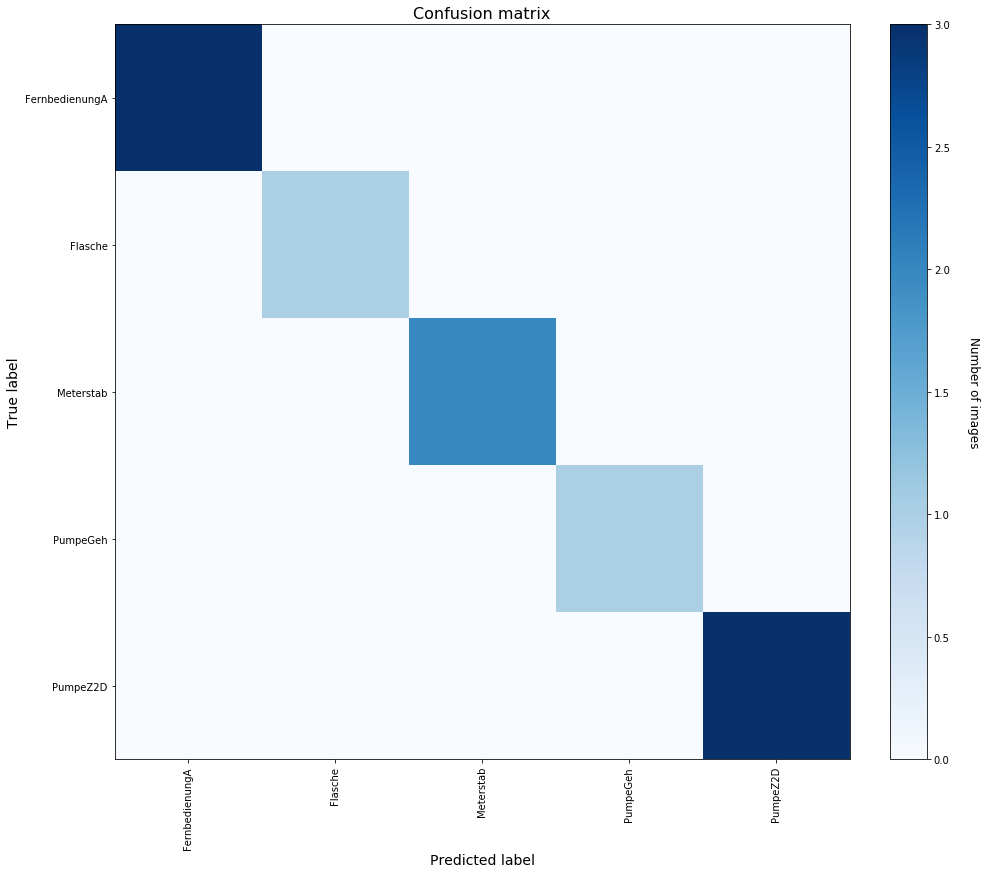

In [40]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,y_pred)*100))
plot_confusion_matrix(y_test,y_pred)